# Run Delphes and extract observables

Johann Brehmer, Kyle Cranmer, Felix Kling, Duccio Pappadopulo, Josh Ruderman 2018

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

import numpy as np
import matplotlib
from matplotlib import pyplot as plt
% matplotlib inline
import logging
import os

from madminer.sampling import SampleAugmenter
from madminer.sampling import multiple_benchmark_thetas
from madminer.sampling import constant_morphing_theta, multiple_morphing_thetas, random_morphing_thetas

logging.basicConfig(format='%(asctime)s  %(message)s', datefmt='%H:%M')


In [2]:
base_dir = '/Users/johannbrehmer/work/projects/madminer/diboson_mining/'
mg_dir = '/Users/johannbrehmer/work/projects/madminer/MG5_aMC_v2_6_2/'

In [3]:
sample_dir = base_dir + 'data/samples/wgamma/'
card_dir = base_dir + 'cards/wgamma/'
ufo_model_dir = card_dir + 'SMWgamma_UFO'
run_card_dir = card_dir + 'run_cards/'
mg_process_dir = base_dir + 'data/mg_processes/wgamma/'
log_dir = base_dir + 'logs/wgamma/'
temp_dir = base_dir + 'data/temp'
delphes_dir = mg_dir + 'Delphes'

## Load data

In [4]:
sa = SampleAugmenter(sample_dir + 'samples.h5', debug=False)

11:03  
11:03  ------------------------------------------------------------
11:03  |                                                          |
11:03  |  MadMiner v2018.10.11                                    |
11:03  |                                                          |
11:03  |           Johann Brehmer, Kyle Cranmer, and Felix Kling  |
11:03  |                                                          |
11:03  ------------------------------------------------------------
11:03  
11:03  Loading data from /Users/johannbrehmer/work/projects/madminer/diboson_mining/data/samples/wgamma/samples.h5
11:03  Found 2 parameters:
11:03     cWWW (LHA: dim6 1, maximal power in squared ME: (2,), range: (-0.1, 0.1))
11:03     cWWWtilde (LHA: dim6 2, maximal power in squared ME: (2,), range: (-0.1, 0.1))
11:03  Found 6 benchmarks:
11:03     sm: cWWW = 0.00e+00, cWWWtilde = 0.00e+00
11:03     morphing_basis_vector_1: cWWW = -9.39e-02, cWWWtilde = 0.07
11:03     morphing_basis_vector_2: cWWW = 0.

## Training and test data

In [5]:
_, _, _ = sa.extract_samples_train_local(
    theta=constant_morphing_theta([0.,0.]),
    n_samples=1000000,
    folder=sample_dir + 'train_local',
    filename='train_local',
    test_split=0.5
)

11:03  Extracting training sample for local score regression. Sampling and score evaluation according to ('theta', array([0., 0.]))


In [6]:
x_sm, _ = sa.extract_samples_test(
    theta=constant_morphing_theta([0.,0.]),
    n_samples=1000000,
    folder=sample_dir + 'test_local',
    filename='test',
    test_split=0.5
)

11:03  Extracting evaluation sample. Sampling according to ('theta', array([0., 0.]))


## xsec test

In [7]:
thetas_benchmarks, xsecs_benchmarks, xsec_errors_benchmarks = sa.extract_cross_sections(
    theta=multiple_benchmark_thetas(['sm', 'morphing_basis_vector_1', 'morphing_basis_vector_2', 'morphing_basis_vector_3', 'morphing_basis_vector_4', 'morphing_basis_vector_5'])
)

thetas_morphing, xsecs_morphing, xsec_errors_morphing = sa.extract_cross_sections(
    theta=random_morphing_thetas(1000, [('gaussian', 0., 0.05), ('gaussian', 0., 0.05)])
)

11:03  Starting cross-section calculation
11:03  Starting cross-section calculation


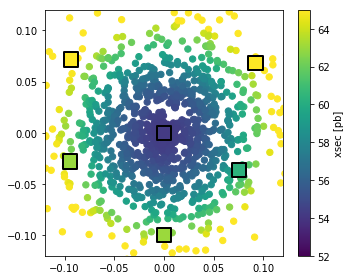

In [8]:
fig = plt.figure(figsize=(5,4))

sc = plt.scatter(thetas_morphing[:,0], thetas_morphing[:,1], c=xsecs_morphing,
            s=40., cmap='viridis', vmin=52., vmax=65.,
            marker='o')

plt.scatter(thetas_benchmarks[:,0], thetas_benchmarks[:,1], c=xsecs_benchmarks,
            s=200., cmap='viridis', vmin=52., vmax=65.,lw=2., edgecolor='black',
            marker='s')

cb = plt.colorbar(sc)
cb.set_label('xsec [pb]')

plt.xlim(-0.12,.12)
plt.ylim(-0.12,.12)
plt.tight_layout()
plt.show()

## Observable distributions

In [9]:
x_bsm1, _ = sa.extract_samples_test(
    theta=constant_morphing_theta([0.1,0.]),
    n_samples=1000000,
    folder=None,
    filename=None,
    test_split=0.5
)

x_bsm2, _ = sa.extract_samples_test(
    theta=constant_morphing_theta([0.,0.1]),
    n_samples=1000000,
    folder=None,
    filename=None,
    test_split=0.5
)

11:03  Extracting evaluation sample. Sampling according to ('theta', array([0.1, 0. ]))
11:03  Extracting evaluation sample. Sampling according to ('theta', array([0. , 0.1]))


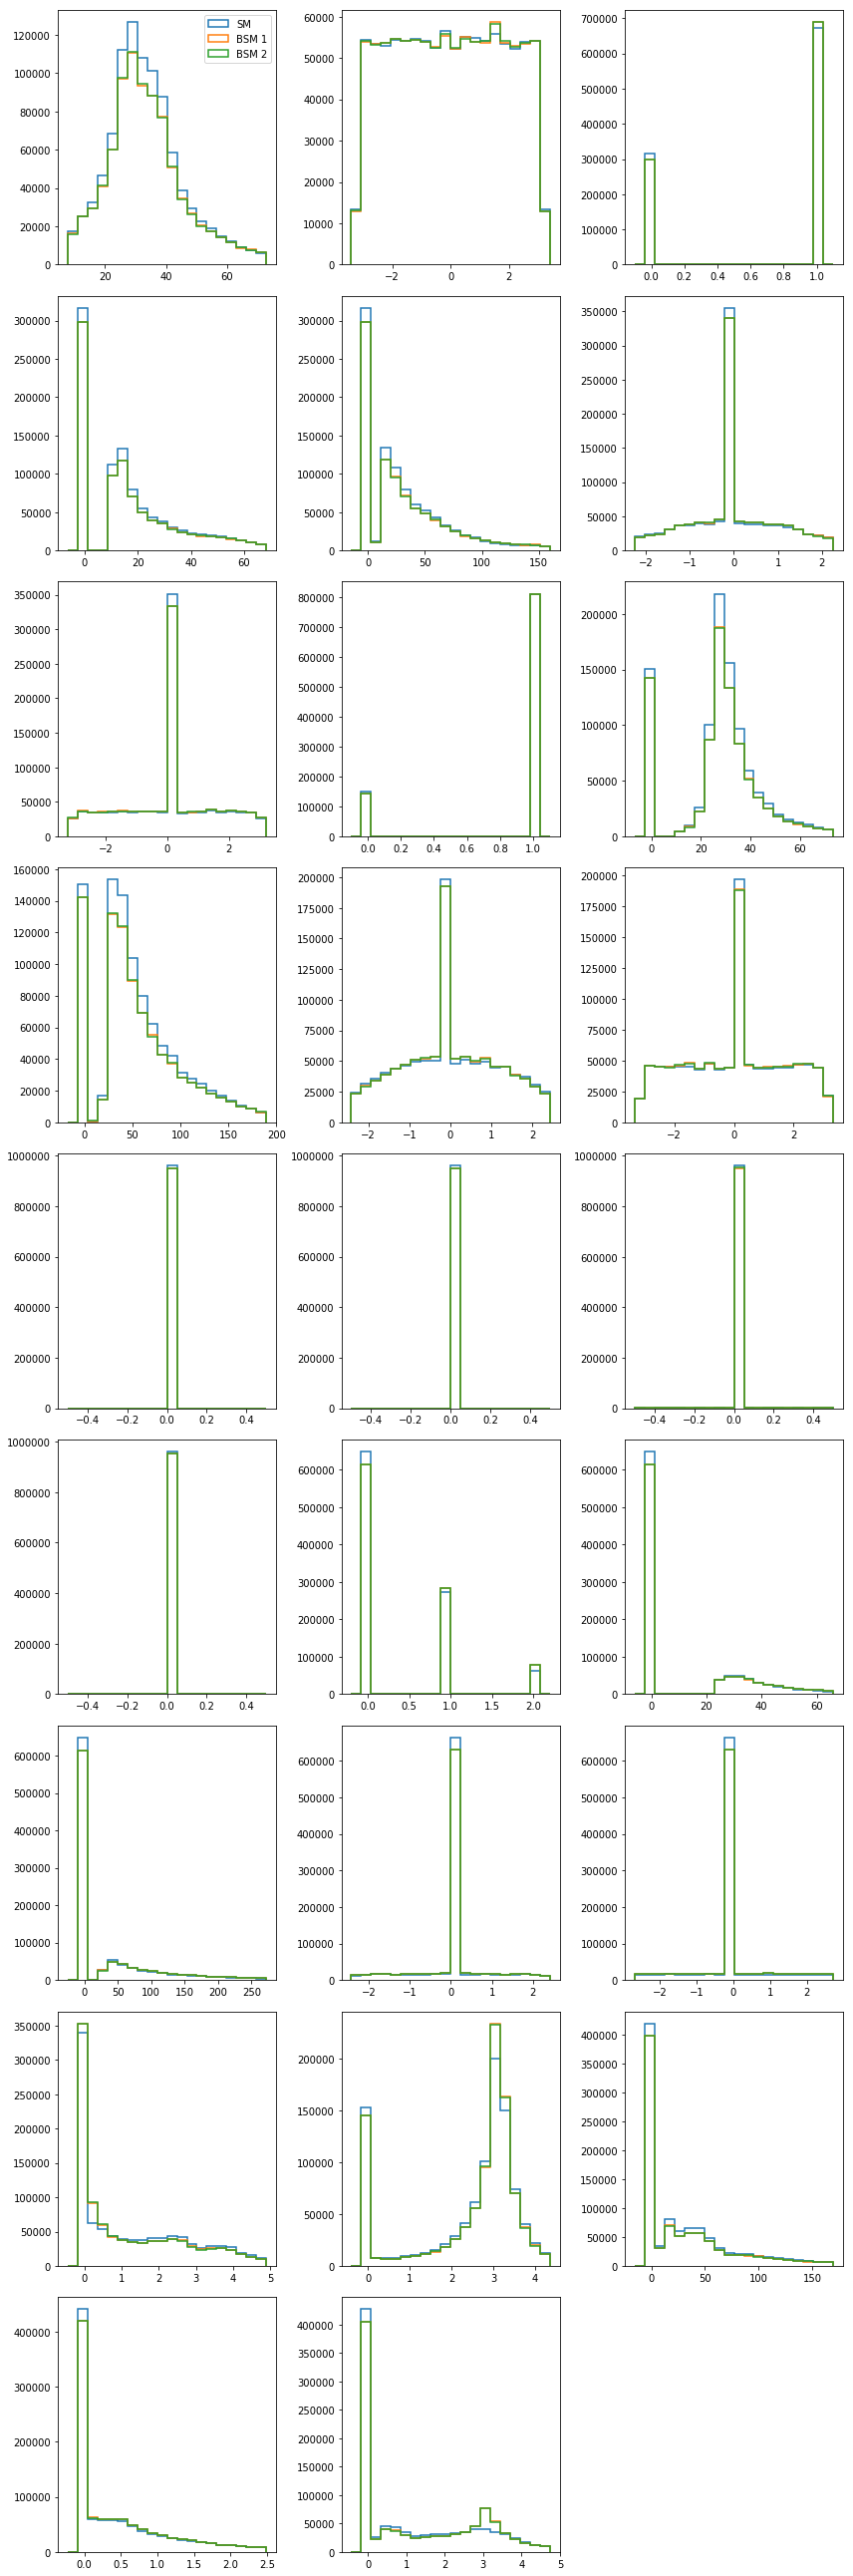

In [13]:
bins = 20
n_observables = x_sm.shape[1]
n_cols = 3
n_rows = (n_observables + n_cols - 1) // n_cols

plt.figure(figsize=(4. * n_cols, 4. * n_rows))

for i in range(n_observables):
    xmin = np.percentile(x_sm[:,i], 5.)
    xmax = np.percentile(x_sm[:,i], 95.)
    xwidth = xmax - xmin
    xmin -= xwidth * 0.1
    xmax += xwidth * 0.1
    x_range = (xmin, xmax)
    
    ax = plt.subplot(n_rows, n_cols, i+1)
       
    plt.hist(x_sm[:,i], histtype='step', range=x_range, bins=bins, lw=1.5, label=r'SM') 
    plt.hist(x_bsm1[:,i], histtype='step', range=x_range, bins=bins, lw=1.5, label=r'BSM 1')
    plt.hist(x_bsm2[:,i], histtype='step', range=x_range, bins=bins, lw=1.5, label=r'BSM 2') 
    
    if i == 0:
        plt.legend()
    
plt.tight_layout()
plt.show()